# Multi-group Agreement (Income)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Income
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from folktables import ACSDataSource, ACSIncome

# ACS Income Dataset (2016, California)
The ACS Employment is a benchmark derived from the 2018 American Community Survey. The task is to predict whether an 
individual has a income over $50,000 after filtering the survey to include only individuals above the age of 16, who reported
usual working hours of at least 1 hour per week in the previous year, and an income of at least $100.
The full dataset has $n = 1,664,500$ examples, but we use a subsample of the dataset from California in 2016 to get a dataset
of $n = 190, 187$ examples total.

## Preprocess and Clean ACS Income
The ACS Income dataset (California, 2016) is a binary classification task with $d=10$ features.

We run the following experiments with the following (overlapping) group structure, $\mathcal{G}$. We let $|\mathcal{G}| = 12.$
- **Race.** Note that we dropped race values $4$ and $5$ because they are too small in the dataset (*Alaska Native alone*
and *American Indian and Alaska Native tribes specified*). The possible values for race are:
  - White alone
  - Black or African-American alone
  - American Indian alone
  - Asian alone
  - Native Hawaiian and Other Pacific Islander alone
  - Some Other Race alone
  - Two or More Races
- **Sex.** The possible values for sex are:
  - Male
  - Female
- **Age.** Split between $\mathrm{Age} > 65$ and $\mathrm{Age} \leq 65$. The possible values for age are:
  - 0 - 99 (integers)

In [2]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)
print("ACS Income Features: {}".format(ACSIncome.features))
print("ACS Income Shape {}".format(features.shape))

ACS Income Features: ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']
ACS Income Shape (190187, 10)


In [3]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [4]:
to_one_hot = set(['COW', 'MAR', 'OCCP', 'POBP', 'RELP', 'RAC1P'])
to_leave_alone = set(ACSIncome.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSIncome.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSIncome.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', MinMaxScaler(), leave_alone_inds)]
col_transf = ColumnTransformer(steps)
features_t = col_transf.fit_transform(features).toarray()
print("Column-transformed X has shape: {}".format(features_t.shape))

Column-transformed X has shape: (190187, 733)


In [5]:
# Train-test split
splits = train_test_split(*tuple([features, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	152149	38038
1 (R1)	94588	23624
2 (R2)	6965	1691
3 (R3)	938	222
4 (R6)	24273	6067
5 (R7)	546	153
6 (R8)	18615	4670
7 (R9)	5887	1523
8 (S1)	80916	20209
9 (S2)	71233	17829
10 (A1)	143354	35822
11 (A2)	8795	2216


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.37969924812030076
P(Y=1 | group 1) = 0.41500169319336266
P(Y=1 | group 2) = 0.3116499112950917
P(Y=1 | group 3) = 0.23423423423423423
P(Y=1 | group 4) = 0.45953519037415524
P(Y=1 | group 5) = 0.1830065359477124
P(Y=1 | group 6) = 0.15331905781584582
P(Y=1 | group 7) = 0.33223900196979644
P(Y=1 | group 8) = 0.42817556534217427
P(Y=1 | group 9) = 0.3247518088507488
P(Y=1 | group 10) = 0.3703310814583217
P(Y=1 | group 11) = 0.5311371841155235


## Utilities for Training/Evaluation

In [8]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [9]:
# Construct pairs of groups for "agreement" comparison
race_sex_train = {}
race_sex_test = {}
race_age_train = {}
race_age_test = {}
sex_age_train = {}
sex_age_test = {}

# Race-Sex Intersections
for r in range(1, 8):
    race_sex_train[r] = {}
    race_sex_test[r] = {}

    race_sex_train[r][8] = group_train[r] & group_train[8]
    race_sex_train[r][9] = group_train[r] & group_train[9]
    race_sex_test[r][8] = group_test[r] & group_test[8]
    race_sex_test[r][9] = group_test[r] & group_test[9]

# Race-Age Intersections
for r in range(1, 8):
    race_age_train[r] = {}
    race_age_test[r] = {}

    race_age_train[r][10] = group_train[r] & group_train[10]
    race_age_train[r][11] = group_train[r] & group_train[11]
    race_age_test[r][10] = group_test[r] & group_test[10]
    race_age_test[r][11] = group_test[r] & group_test[11]

# Sex-Age Intersections
sex_age_train[8] = {}
sex_age_train[9] = {}
sex_age_train[8][10] = group_train[8] & group_train[10]
sex_age_train[8][11] = group_train[8] & group_train[11]
sex_age_train[9][10] = group_train[9] & group_train[10]
sex_age_train[9][11] = group_train[9] & group_train[11]

sex_age_test[8] = {}
sex_age_test[9] = {}
sex_age_test[8][10] = group_test[8] & group_test[10]
sex_age_test[8][11] = group_test[8] & group_test[11]
sex_age_test[9][10] = group_test[9] & group_test[10]
sex_age_test[9][11] = group_test[9] & group_test[11]

In [10]:
# Race-Sex Group Intersections
race_sex_pairs = list()
for r in range(1, 8):
    race_sex_pairs.append((r, 8)) # (race, S1)
    race_sex_pairs.append((r, 9)) # (race, S2)

race_age_pairs = list()
for r in range(1, 8):
    race_age_pairs.append((r, 10)) # (race, A1)
    race_age_pairs.append((r, 11)) # (race, A2)

sex_age_pairs = list()
sex_age_pairs.append((8, 10))
sex_age_pairs.append((8, 11))
sex_age_pairs.append((9, 10))
sex_age_pairs.append((9, 11))

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [12]:
# Train LogisticRegression models, one per group
LOAD_DATA = True
SAVE_DATA_PATH = 'income_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

# Train LogisticRegression models, one per group

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17692833482307166 (+/-0.0027670925263652956; n=38038)
group 1 (R1): 0.18637825939722316 (+/-0.0035830030592924607; n=23624)
group 2 (R2): 0.2034299231224128 (+/-0.013844032353922972; n=1691)
group 3 (R3): 0.24774774774774774 (+/-0.04097558064643266; n=222)
group 4 (R6): 0.1883962419647272 (+/-0.007099636978122833; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.1252676659528908 (+/-0.006850363869721284; n=4670)
group 7 (R9): 0.175311884438608 (+/-0.013778933153021899; n=1523)
group 8 (S1): 0.1836805383739918 (+/-0.0038521592518664187; n=20209)
group 9 (S2): 0.1719109316282461 (+/-0.003996149967434278; n=17829)
group 10 (A1): 0.17204511194238178 (+/-0.0028201005247985435; n=35822)
group 11 (A2): 0.26173285198555957 (+/-0.013205839363728454; n=2216)


In [13]:
# Get group-conditional agreements for Race-Sex pairs
lr_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9731338607347066
R1 and S2 agreement on (R1, S2):	0.9662890301188174
R2 and S1 agreement on (R2, S1):	0.9210836277974087
R2 and S2 agreement on (R2, S2):	0.9204275534441805
R3 and S1 agreement on (R3, S1):	0.8983050847457628
R3 and S2 agreement on (R3, S2):	0.8942307692307693
R6 and S1 agreement on (R6, S1):	0.9395241242564442
R6 and S2 agreement on (R6, S2):	0.9513317987504111
R7 and S1 agreement on (R7, S1):	0.8194444444444444
R7 and S2 agreement on (R7, S2):	0.8641975308641975
R8 and S1 agreement on (R8, S1):	0.9564032697547684
R8 and S2 agreement on (R8, S2):	0.9690623512613041
R9 and S1 agreement on (R9, S1):	0.9316688567674113
R9 and S2 agreement on (R9, S2):	0.9343832020997376


In [14]:
lr_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({},{}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1,A1):	0.9805316190215657
R1 and A2 agreement on (R1,A2):	0.914843287995269
R2 and A1 agreement on (R2,A1):	0.9314033983637507
R2 and A2 agreement on (R2,A2):	0.8431372549019608
R3 and A1 agreement on (R3,A1):	0.8925233644859814
R3 and A2 agreement on (R3,A2):	0.875
R6 and A1 agreement on (R6,A1):	0.9568457538994801
R6 and A2 agreement on (R6,A2):	0.8686868686868687
R7 and A1 agreement on (R7,A1):	0.8571428571428571
R7 and A2 agreement on (R7,A2):	0.5
R8 and A1 agreement on (R8,A1):	0.9612875163114397
R8 and A2 agreement on (R8,A2):	0.9027777777777778
R9 and A1 agreement on (R9,A1):	0.9367003367003367
R9 and A2 agreement on (R9,A2):	0.8947368421052632


In [15]:
lr_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({},{}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1,A1):	0.9744291276439019
S1 and A2 agreement on (S1,A2):	0.9027431421446384
S2 and A1 agreement on (S2,A1):	0.9683039961941009
S2 and A2 agreement on (S2,A2):	0.9012833168805529


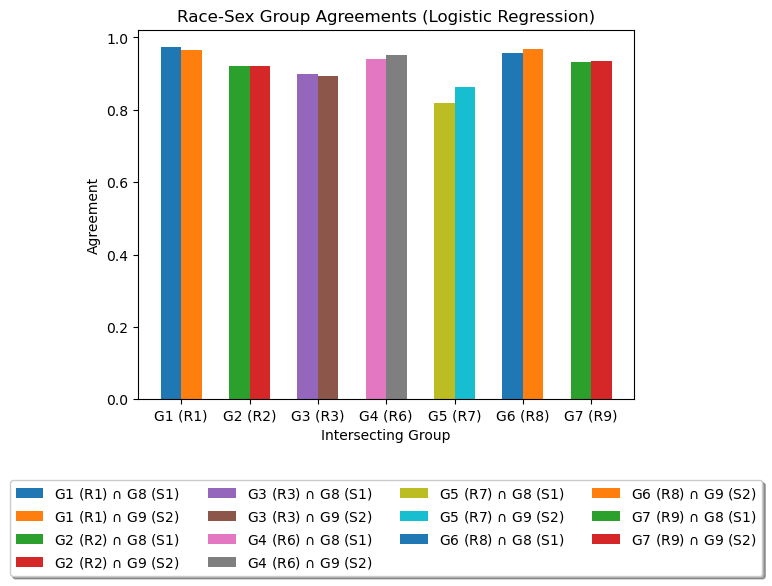

In [16]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

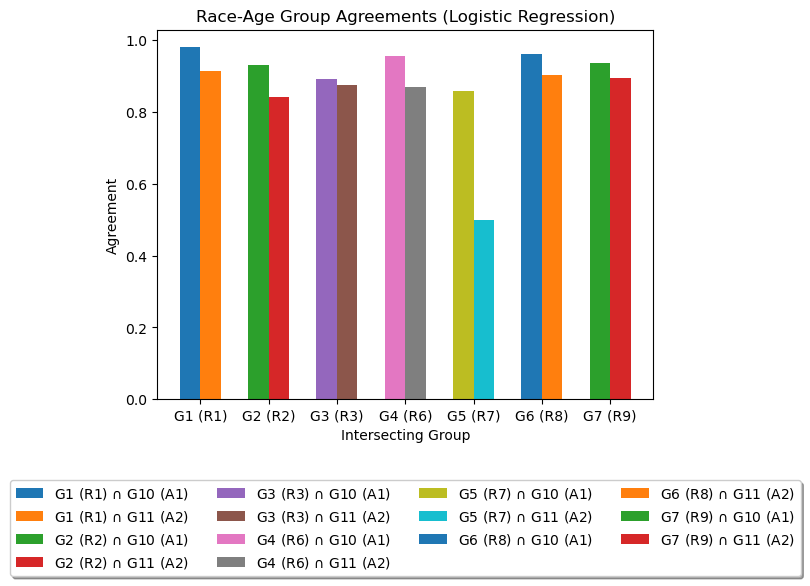

In [17]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

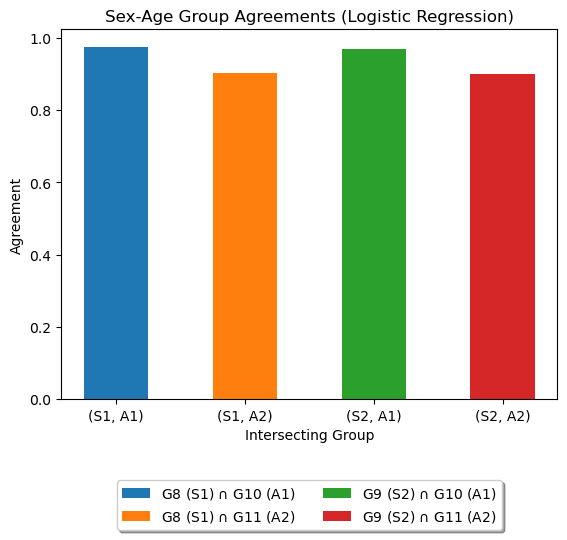

In [18]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, lr_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, lr_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, lr_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, lr_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

## Take a look at the A2 classifier

In [19]:
# test errors again
lr_test_err = {}
for g in range(num_groups):
    lr_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,lr_test_err[g], std_err(lr_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17692833482307166 (+/-0.0027670925263652956; n=38038)
group 1 (R1): 0.18637825939722316 (+/-0.0035830030592924607; n=23624)
group 2 (R2): 0.2034299231224128 (+/-0.013844032353922972; n=1691)
group 3 (R3): 0.24774774774774774 (+/-0.04097558064643266; n=222)
group 4 (R6): 0.1883962419647272 (+/-0.007099636978122833; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.1252676659528908 (+/-0.006850363869721284; n=4670)
group 7 (R9): 0.175311884438608 (+/-0.013778933153021899; n=1523)
group 8 (S1): 0.1836805383739918 (+/-0.0038521592518664187; n=20209)
group 9 (S2): 0.1719109316282461 (+/-0.003996149967434278; n=17829)
group 10 (A1): 0.17204511194238178 (+/-0.0028201005247985435; n=35822)
group 11 (A2): 0.26173285198555957 (+/-0.013205839363728454; n=2216)


In [20]:
print("P(Y = 1 | G11) =\t{}".format(np.mean(y_test[group_test[11]])))
print("P(h11 = 1 | G11) =\t{}".format(np.mean(yhats[11][group_test[11]])))

P(Y = 1 | G11) =	0.5311371841155235
P(h11 = 1 | G11) =	0.5509927797833934


# Decision Trees

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
LOAD_DATA = True
SAVE_DATA_PATH = 'income_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

dt_test_err = {}
for g in range(num_groups):
    dt_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,dt_test_err[g], std_err(dt_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.2027709132972291 (+/-0.0029154161627747395; n=38038)
group 1 (R1): 0.21262275651879445 (+/-0.0037647364802994537; n=23624)
group 2 (R2): 0.22945002956830277 (+/-0.01446064475045787; n=1691)
group 3 (R3): 0.22072072072072071 (+/-0.03936467115094497; n=222)
group 4 (R6): 0.21279050601615296 (+/-0.0074310346369590875; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.145610278372591 (+/-0.007299289373315398; n=4670)
group 7 (R9): 0.2206172028890348 (+/-0.01502657976323175; n=1523)
group 8 (S1): 0.20921371666089367 (+/-0.004046385232847114; n=20209)
group 9 (S2): 0.1916540467777217 (+/-0.004168781534711169; n=17829)
group 10 (A1): 0.1963039472949584 (+/-0.002967908564050363; n=35822)
group 11 (A2): 0.30415162454873645 (+/-0.013820778248771507; n=2216)


In [23]:
# Get group-conditional agreements for Race-Sex pairs
dt_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    dt_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9169734471684813
R1 and S2 agreement on (R1, S2):	0.9308280372110159
R2 and S1 agreement on (R2, S1):	0.856301531213192
R2 and S2 agreement on (R2, S2):	0.9061757719714965
R3 and S1 agreement on (R3, S1):	0.8389830508474576
R3 and S2 agreement on (R3, S2):	0.9038461538461539
R6 and S1 agreement on (R6, S1):	0.906146728354263
R6 and S2 agreement on (R6, S2):	0.9003617231173956
R7 and S1 agreement on (R7, S1):	0.8611111111111112
R7 and S2 agreement on (R7, S2):	0.8024691358024691
R8 and S1 agreement on (R8, S1):	0.9493966523939276
R8 and S2 agreement on (R8, S2):	0.9552594002855783
R9 and S1 agreement on (R9, S1):	0.8423127463863338
R9 and S2 agreement on (R9, S2):	0.931758530183727


In [24]:
# Get group-conditional agreements for Race-Age pairs
dt_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    dt_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9267770026900105
R1 and A2 agreement on (R1, A2):	0.8255470136014192
R2 and A1 agreement on (R2, A1):	0.8766519823788547
R2 and A2 agreement on (R2, A2):	0.6764705882352942
R3 and A1 agreement on (R3, A1):	0.897196261682243
R3 and A2 agreement on (R3, A2):	0.5
R6 and A1 agreement on (R6, A1):	0.9093587521663778
R6 and A2 agreement on (R6, A2):	0.7643097643097643
R7 and A1 agreement on (R7, A1):	0.8571428571428571
R7 and A2 agreement on (R7, A2):	0.6666666666666666
R8 and A1 agreement on (R8, A1):	0.950195737277077
R8 and A2 agreement on (R8, A2):	0.8194444444444444
R9 and A1 agreement on (R9, A1):	0.8888888888888888
R9 and A2 agreement on (R9, A2):	0.8421052631578947


In [25]:
# Get group-conditional agreements for Sex-Age pairs
dt_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    dt_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9253919814795328
S1 and A2 agreement on (S1, A2):	0.7822111388196176
S2 and A1 agreement on (S2, A1):	0.9568268315889629
S2 and A2 agreement on (S2, A2):	0.7838104639684107


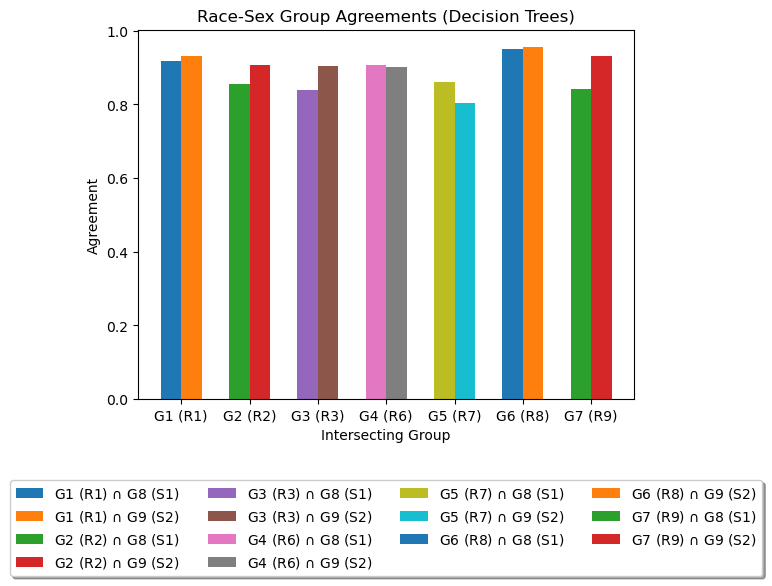

In [26]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

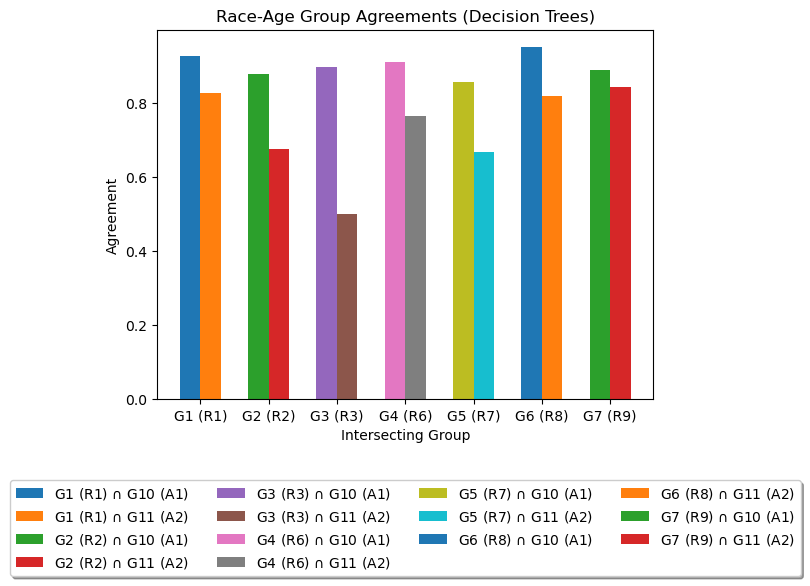

In [27]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

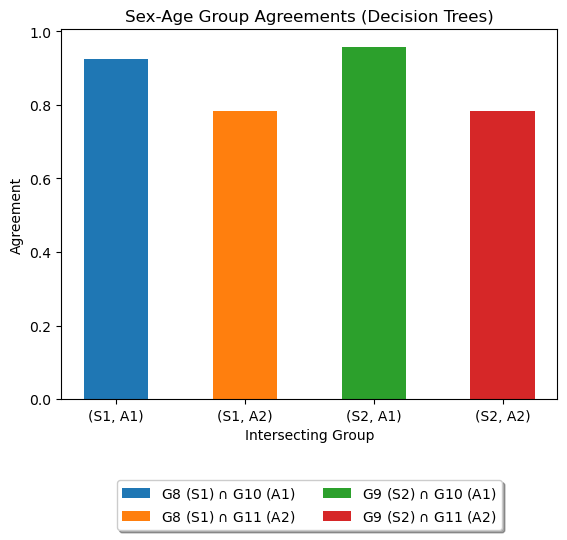

In [28]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, dt_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, dt_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, dt_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, dt_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Random Forests

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
LOAD_DATA = True
SAVE_DATA_PATH = 'income_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'rf_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'rf_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'rf_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    rf_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        rf_models[g] = RandomForestClassifier(**best_params[g])
        rf_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = rf_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_test_err = {}
for g in range(num_groups):
    rf_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, rf_test_err[g], std_err(rf_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17472001682528 (+/-0.0027534560451815695; n=38038)
group 1 (R1): 0.18333051134439554 (+/-0.0035602362753263312; n=23624)
group 2 (R2): 0.19751626256652868 (+/-0.013691869264644505; n=1691)
group 3 (R3): 0.20270270270270271 (+/-0.03815736938018025; n=222)
group 4 (R6): 0.18823141585627162 (+/-0.007097251165265071; n=6067)
group 5 (R7): 0.20261437908496732 (+/-0.04595561832742493; n=153)
group 6 (R8): 0.1252676659528908 (+/-0.006850363869721284; n=4670)
group 7 (R9): 0.17596848325673015 (+/-0.013799215682654206; n=1523)
group 8 (S1): 0.18229501707160176 (+/-0.0038408584919796974; n=20209)
group 9 (S2): 0.17017219137360481 (+/-0.003980061596090945; n=17829)
group 10 (A1): 0.17067723745184524 (+/-0.002811186627866301; n=35822)
group 11 (A2): 0.25406137184115524 (+/-0.013078290744207478; n=2216)


In [31]:
# Get group-conditional agreements for Race-Sex pairs
rf_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    rf_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9700791102059998
R1 and S2 agreement on (R1, S2):	0.9673943078198397
R2 and S1 agreement on (R2, S1):	0.928150765606596
R2 and S2 agreement on (R2, S2):	0.9133016627078385
R3 and S1 agreement on (R3, S1):	0.8305084745762712
R3 and S2 agreement on (R3, S2):	0.9230769230769231
R6 and S1 agreement on (R6, S1):	0.956708526107072
R6 and S2 agreement on (R6, S2):	0.9536336731338375
R7 and S1 agreement on (R7, S1):	0.8611111111111112
R7 and S2 agreement on (R7, S2):	0.9382716049382716
R8 and S1 agreement on (R8, S1):	0.9731413001167769
R8 and S2 agreement on (R8, S2):	0.9842931937172775
R9 and S1 agreement on (R9, S1):	0.9434954007884363
R9 and S2 agreement on (R9, S2):	0.9488188976377953


In [32]:
# Get group-conditional agreements for Race-Sex pairs
rf_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    rf_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9733734555236402
R1 and A2 agreement on (R1, A2):	0.9012418687167356
R2 and A1 agreement on (R2, A1):	0.9307740717432348
R2 and A2 agreement on (R2, A2):	0.803921568627451
R3 and A1 agreement on (R3, A1):	0.8785046728971962
R3 and A2 agreement on (R3, A2):	0.875
R6 and A1 agreement on (R6, A1):	0.9620450606585789
R6 and A2 agreement on (R6, A2):	0.8787878787878788
R7 and A1 agreement on (R7, A1):	0.9251700680272109
R7 and A2 agreement on (R7, A2):	0.8333333333333334
R8 and A1 agreement on (R8, A1):	0.9806437581557199
R8 and A2 agreement on (R8, A2):	0.9722222222222222
R9 and A1 agreement on (R9, A1):	0.9501683501683502
R9 and A2 agreement on (R9, A2):	0.868421052631579


In [33]:
# Get group-conditional agreements for Sex-Age pairs
rf_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    rf_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9696411659475955
S1 and A2 agreement on (S1, A2):	0.8935993349958438
S2 and A1 agreement on (S2, A1):	0.9722288296860133
S2 and A2 agreement on (S2, A2):	0.8983218163869694


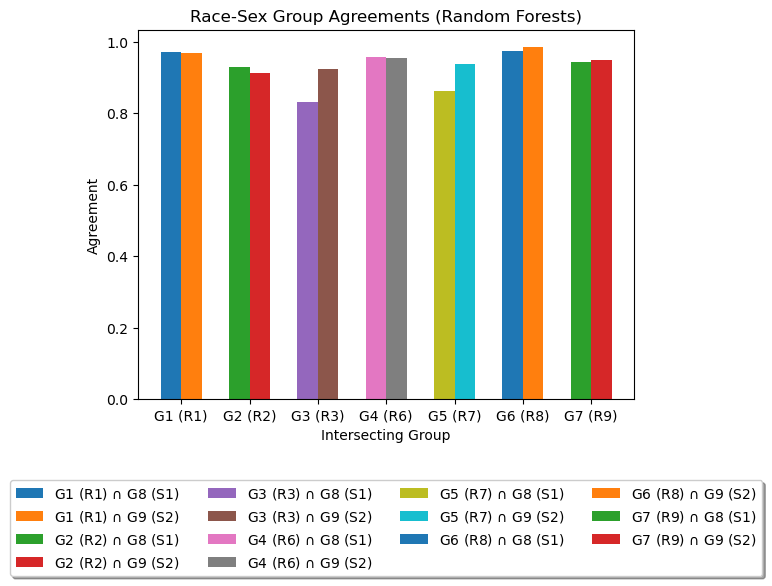

In [34]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, rf_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, rf_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Random Forests)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

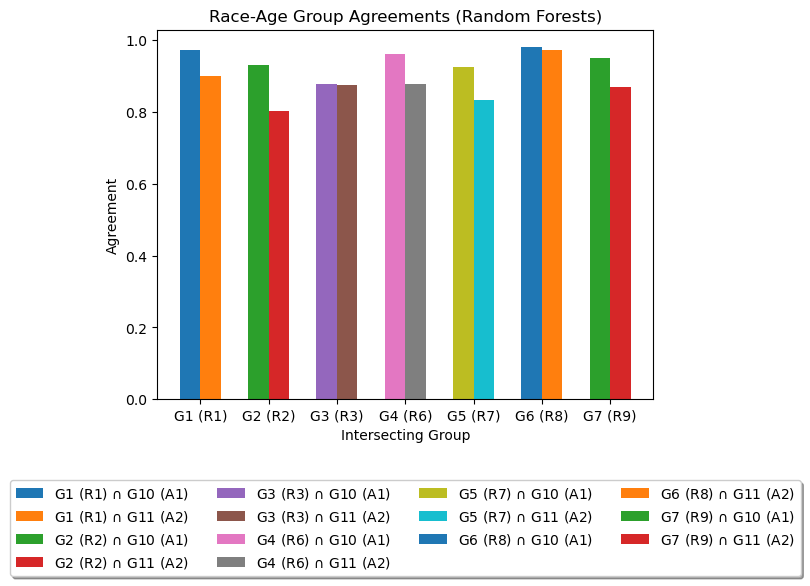

In [35]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, rf_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, rf_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Random Forests)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

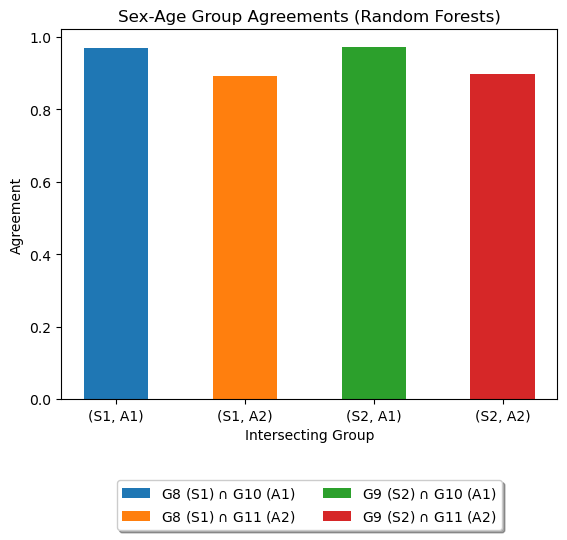

In [36]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, rf_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, rf_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, rf_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, rf_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Random Forests)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Gradient-Boosted Trees

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
LOAD_DATA = True
SAVE_DATA_PATH = 'income_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

gb_test_err = {}
for g in range(num_groups):
    gb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, gb_test_err[g], std_err(gb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.1767443083232557 (+/-0.002765962261427566; n=38038)
group 1 (R1): 0.18608195055875382 (+/-0.0035808056120478758; n=23624)
group 2 (R2): 0.1981076286221171 (+/-0.013707297374228995; n=1691)
group 3 (R3): 0.22972972972972974 (+/-0.03992718383609589; n=222)
group 4 (R6): 0.19037415526619417 (+/-0.007128106447293117; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.12740899357601712 (+/-0.006900204569228413; n=4670)
group 7 (R9): 0.1799080761654629 (+/-0.013919436157737029; n=1523)
group 8 (S1): 0.18194863674600426 (+/-0.003838020368572115; n=20209)
group 9 (S2): 0.171350047675136 (+/-0.003990976540933219; n=17829)
group 10 (A1): 0.17168220646530066 (+/-0.002817741974860067; n=35822)
group 11 (A2): 0.25676895306859204 (+/-0.013123911603785711; n=2216)


In [39]:
# Get group-conditional agreements for Race-Sex pairs
gb_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    gb_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9359285658337902
R1 and S2 agreement on (R1, S2):	0.948051948051948
R2 and S1 agreement on (R2, S1):	0.8881036513545347
R2 and S2 agreement on (R2, S2):	0.9133016627078385
R3 and S1 agreement on (R3, S1):	0.8135593220338984
R3 and S2 agreement on (R3, S2):	0.9230769230769231
R6 and S1 agreement on (R6, S1):	0.9084600132187707
R6 and S2 agreement on (R6, S2):	0.933903321275896
R7 and S1 agreement on (R7, S1):	0.8055555555555556
R7 and S2 agreement on (R7, S2):	0.8395061728395061
R8 and S1 agreement on (R8, S1):	0.9447255741533671
R8 and S2 agreement on (R8, S2):	0.9681104236078059
R9 and S1 agreement on (R9, S1):	0.897503285151117
R9 and S2 agreement on (R9, S2):	0.9251968503937008


In [40]:
# Get group-conditional agreements for Race-Sex pairs
gb_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    gb_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9491177677472302
R1 and A2 agreement on (R1, A2):	0.8994677705499704
R2 and A1 agreement on (R2, A1):	0.9144115796098174
R2 and A2 agreement on (R2, A2):	0.8725490196078431
R3 and A1 agreement on (R3, A1):	0.8504672897196262
R3 and A2 agreement on (R3, A2):	0.75
R6 and A1 agreement on (R6, A1):	0.9305025996533796
R6 and A2 agreement on (R6, A2):	0.835016835016835
R7 and A1 agreement on (R7, A1):	0.8571428571428571
R7 and A2 agreement on (R7, A2):	0.8333333333333334
R8 and A1 agreement on (R8, A1):	0.9593301435406698
R8 and A2 agreement on (R8, A2):	0.9305555555555556
R9 and A1 agreement on (R9, A1):	0.9205387205387205
R9 and A2 agreement on (R9, A2):	0.8157894736842105


In [41]:
# Get group-conditional agreements for Sex-Age pairs
gb_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    gb_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9423339997895401
S1 and A2 agreement on (S1, A2):	0.8379052369077307
S2 and A1 agreement on (S2, A1):	0.9533182683158896
S2 and A2 agreement on (S2, A2):	0.9062191510365252


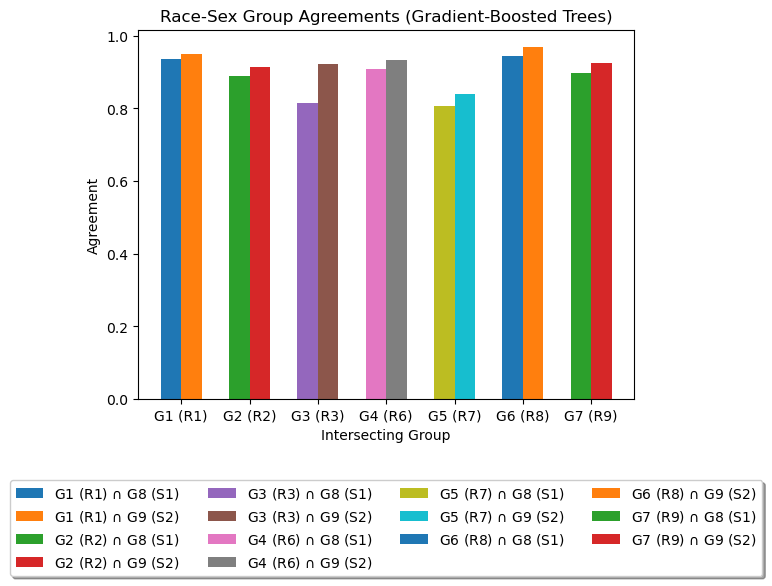

In [42]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

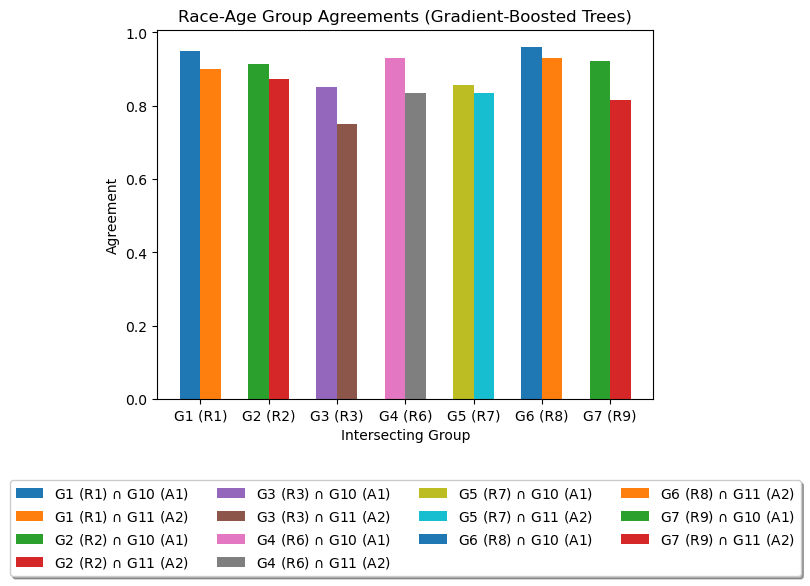

In [43]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

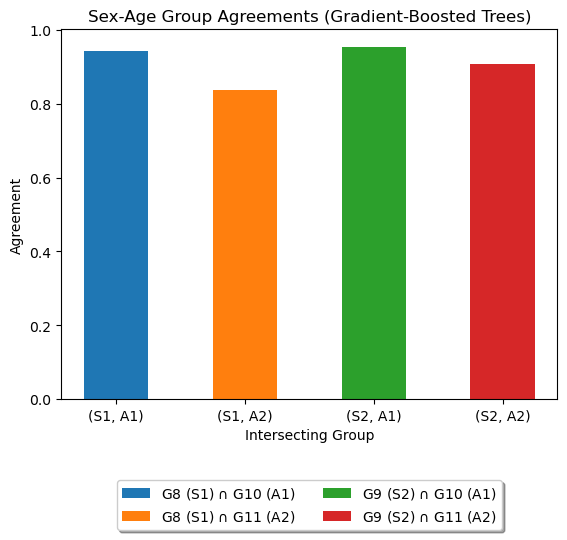

In [44]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, gb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, gb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, gb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, gb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# XGBoost

In [45]:
from xgboost import XGBClassifier

In [46]:
LOAD_DATA = True
SAVE_DATA_PATH = 'income_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

xgb_test_err = {}
for g in range(num_groups):
    xgb_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, xgb_test_err[g], std_err(xgb_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17188075082811924 (+/-0.002735685834918695; n=38038)
group 1 (R1): 0.18184896715204876 (+/-0.003549036302635998; n=23624)
group 2 (R2): 0.205204021289178 (+/-0.013888775506895223; n=1691)
group 3 (R3): 0.22072072072072071 (+/-0.03936467115094497; n=222)
group 4 (R6): 0.1875721114224493 (+/-0.0070876872470694435; n=6067)
group 5 (R7): 0.23529411764705882 (+/-0.04849779940398763; n=153)
group 6 (R8): 0.12419700214132762 (+/-0.006825199146067739; n=4670)
group 7 (R9): 0.1845042678923178 (+/-0.014056561617970913; n=1523)
group 8 (S1): 0.18016725221435995 (+/-0.003823341971541533; n=20209)
group 9 (S2): 0.16697515284087722 (+/-0.0039500846985985934; n=17829)
group 10 (A1): 0.16741108815811512 (+/-0.0027896357762142547; n=35822)
group 11 (A2): 0.25586642599277976 (+/-0.013108778373114492; n=2216)


In [47]:
# Get group-conditional agreements for Race-Sex pairs
xgb_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    xgb_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9419597399545704
R1 and S2 agreement on (R1, S2):	0.9450124343741365
R2 and S1 agreement on (R2, S1):	0.8975265017667845
R2 and S2 agreement on (R2, S2):	0.9109263657957245
R3 and S1 agreement on (R3, S1):	0.8728813559322034
R3 and S2 agreement on (R3, S2):	0.9230769230769231
R6 and S1 agreement on (R6, S1):	0.9239920687376074
R6 and S2 agreement on (R6, S2):	0.9286418941137784
R7 and S1 agreement on (R7, S1):	0.7916666666666666
R7 and S2 agreement on (R7, S2):	0.8518518518518519
R8 and S1 agreement on (R8, S1):	0.935383417672246
R8 and S2 agreement on (R8, S2):	0.9681104236078059
R9 and S1 agreement on (R9, S1):	0.9093298291721419
R9 and S2 agreement on (R9, S2):	0.9304461942257218


In [48]:
# Get group-conditional agreements for Race-Age pairs
xgb_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    xgb_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9473852186203437
R1 and A2 agreement on (R1, A2):	0.8835008870490834
R2 and A1 agreement on (R2, A1):	0.9137822529893015
R2 and A2 agreement on (R2, A2):	0.8333333333333334
R3 and A1 agreement on (R3, A1):	0.8738317757009346
R3 and A2 agreement on (R3, A2):	0.5
R6 and A1 agreement on (R6, A1):	0.9320623916811092
R6 and A2 agreement on (R6, A2):	0.8821548821548821
R7 and A1 agreement on (R7, A1):	0.8435374149659864
R7 and A2 agreement on (R7, A2):	1.0
R8 and A1 agreement on (R8, A1):	0.9560678555893867
R8 and A2 agreement on (R8, A2):	0.8888888888888888
R9 and A1 agreement on (R9, A1):	0.9104377104377105
R9 and A2 agreement on (R9, A2):	0.8947368421052632


In [49]:
# Get group-conditional agreements for Race-Age pairs
xgb_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    xgb_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9432810691360622
S1 and A2 agreement on (S1, A2):	0.8794679966749792
S2 and A1 agreement on (S2, A1):	0.9504638439581351
S2 and A2 agreement on (S2, A2):	0.9012833168805529


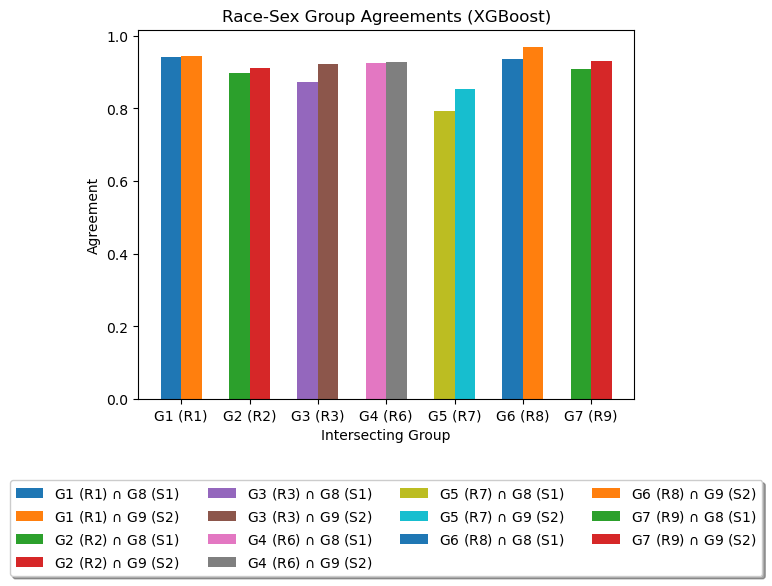

In [50]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

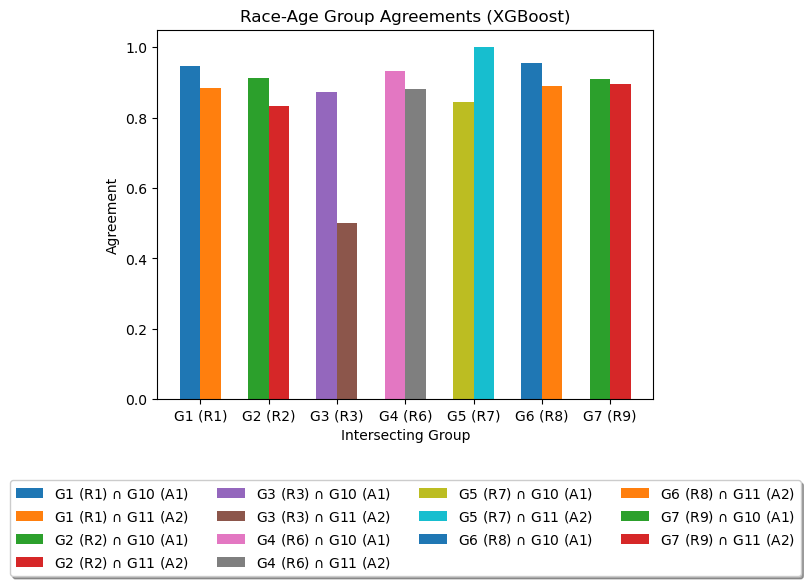

In [51]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

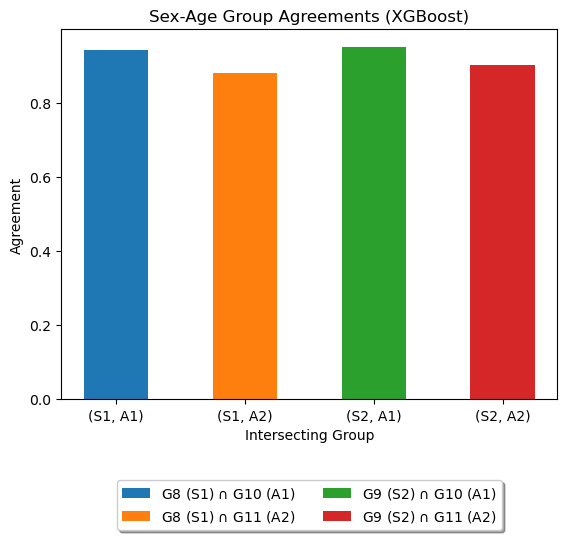

In [52]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, xgb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, xgb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, xgb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, xgb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# AdaBoost

In [53]:
from sklearn.ensemble import AdaBoostClassifier

In [54]:
LOAD_DATA = True
SAVE_DATA_PATH = 'income_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

ada_test_err = {}
for g in range(num_groups):
    ada_test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,ada_test_err[g], std_err(ada_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.19483148430516853 (+/-0.002871964865338586; n=38038)
group 1 (R1): 0.20441076870978667 (+/-0.0037105186142683748; n=23624)
group 2 (R2): 0.2057953873447664 (+/-0.01390359839626906; n=1691)
group 3 (R3): 0.21171171171171171 (+/-0.038775150261476474; n=222)
group 4 (R6): 0.20339541783418494 (+/-0.007308360855938034; n=6067)
group 5 (R7): 0.1895424836601307 (+/-0.04481131546933817; n=153)
group 6 (R8): 0.12933618843683084 (+/-0.006944513610921615; n=4670)
group 7 (R9): 0.1871306631648063 (+/-0.014133440508306762; n=1523)
group 8 (S1): 0.1962491959028156 (+/-0.003951001904995069; n=20209)
group 9 (S2): 0.18481126254977845 (+/-0.004110974735313803; n=17829)
group 10 (A1): 0.18968790128971022 (+/-0.0029294498020649064; n=35822)
group 11 (A2): 0.2694043321299639 (+/-0.013328183202242452; n=2216)


In [55]:
# Get group-conditional agreements for Race-Sex pairs
ada_race_sex_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    ada_race_sex_agreements.append(agreement)

R1 and S1 agreement on (R1, S1):	0.9252761024516332
R1 and S2 agreement on (R1, S2):	0.9343280832642534
R2 and S1 agreement on (R2, S1):	0.9257950530035336
R2 and S2 agreement on (R2, S2):	0.9002375296912114
R3 and S1 agreement on (R3, S1):	0.7627118644067796
R3 and S2 agreement on (R3, S2):	0.9326923076923077
R6 and S1 agreement on (R6, S1):	0.9130865829477859
R6 and S2 agreement on (R6, S2):	0.9414666228214403
R7 and S1 agreement on (R7, S1):	0.7916666666666666
R7 and S2 agreement on (R7, S2):	0.9135802469135802
R8 and S1 agreement on (R8, S1):	0.9326586220319191
R8 and S2 agreement on (R8, S2):	0.9695383150880533
R9 and S1 agreement on (R9, S1):	0.9211563731931669
R9 and S2 agreement on (R9, S2):	0.9422572178477691


In [56]:
# Get group-conditional agreements for Race-Age pairs
ada_race_age_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    ada_race_age_agreements.append(agreement)

R1 and A1 agreement on (R1, A1):	0.9497104819222176
R1 and A2 agreement on (R1, A2):	0.8740390301596689
R2 and A1 agreement on (R2, A1):	0.9263687853996224
R2 and A2 agreement on (R2, A2):	0.9019607843137255
R3 and A1 agreement on (R3, A1):	0.8644859813084113
R3 and A2 agreement on (R3, A2):	0.75
R6 and A1 agreement on (R6, A1):	0.9209705372616984
R6 and A2 agreement on (R6, A2):	0.8619528619528619
R7 and A1 agreement on (R7, A1):	0.8571428571428571
R7 and A2 agreement on (R7, A2):	0.8333333333333334
R8 and A1 agreement on (R8, A1):	0.950195737277077
R8 and A2 agreement on (R8, A2):	0.9166666666666666
R9 and A1 agreement on (R9, A1):	0.9333333333333333
R9 and A2 agreement on (R9, A2):	0.8421052631578947


In [57]:
# Get group-conditional agreements for Sex-Age pairs
ada_sex_age_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("{} and {} agreement on ({}, {}):\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    ada_sex_age_agreements.append(agreement)

S1 and A1 agreement on (S1, A1):	0.9499105545617174
S1 and A2 agreement on (S1, A2):	0.8719866999168745
S2 and A1 agreement on (S2, A1):	0.9357159847764034
S2 and A2 agreement on (S2, A2):	0.8835143139190523


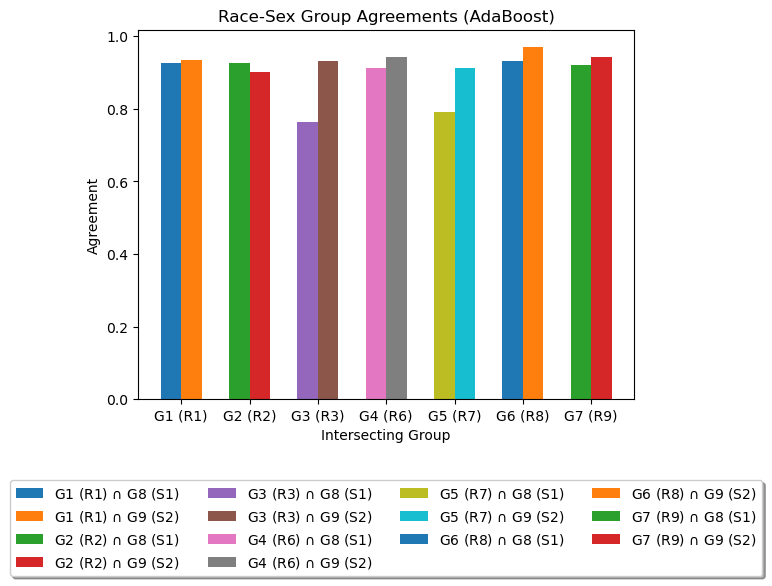

In [58]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

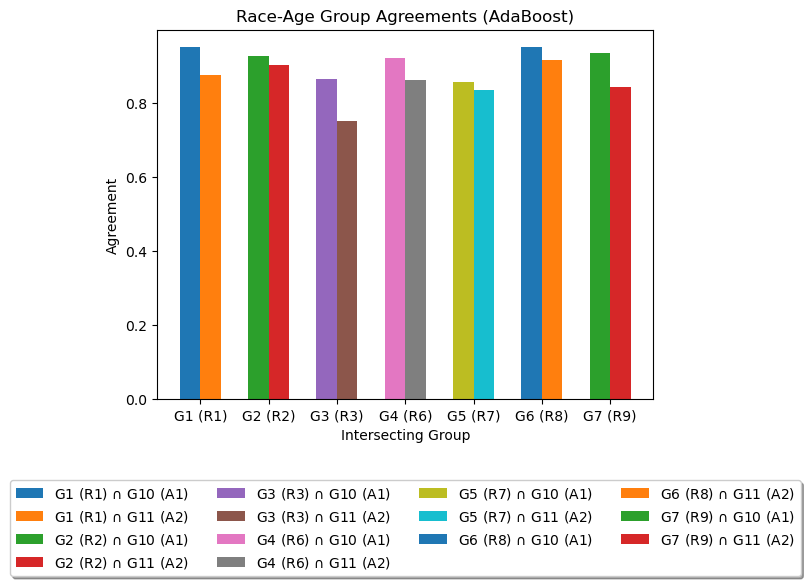

In [59]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

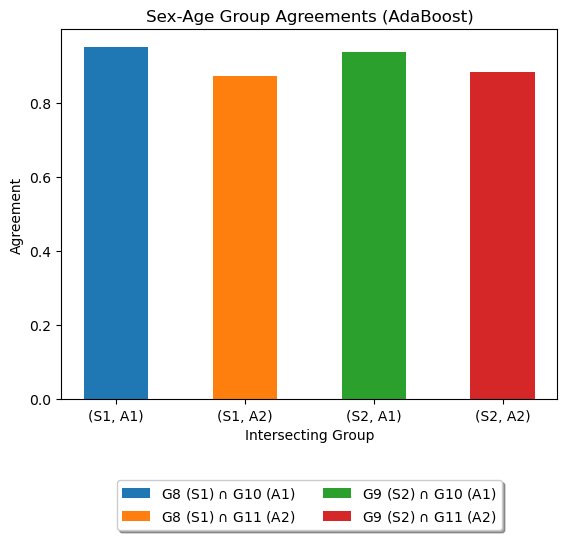

In [60]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, ada_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, ada_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, ada_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, ada_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# All Together

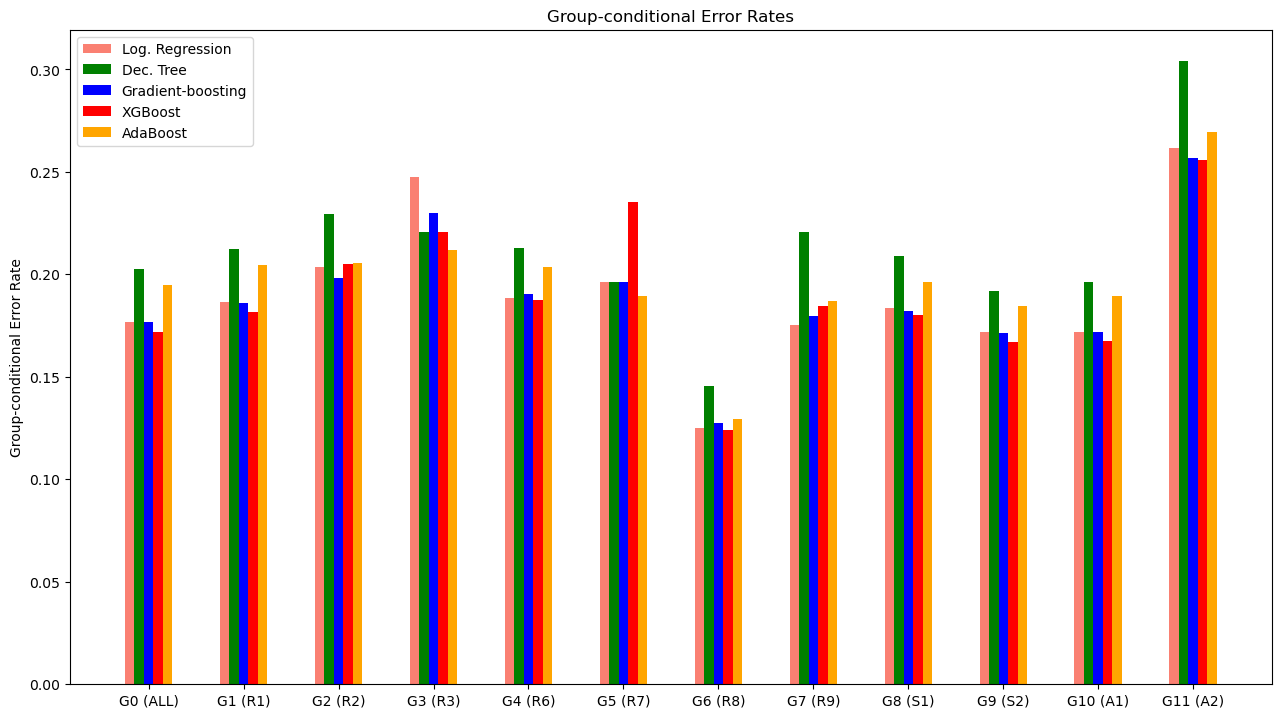

In [61]:
# Error rate plots
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
bar_width = 0.1
index = np.arange(num_groups)

for g in range(num_groups):
    if g == 0:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, label="Log. Regression", color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, label="Dec. Tree", color="green")
        ax.bar(g, gb_test_err[g], bar_width, label="Gradient-boosting", color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, label="XGBoost", color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, label="AdaBoost", color="orange")
    else:
        ax.bar(g - 2 * bar_width, lr_test_err[g], bar_width, color="salmon")
        ax.bar(g - 1 * bar_width, dt_test_err[g], bar_width, color="green")
        ax.bar(g, gb_test_err[g], bar_width, color="blue")
        ax.bar(g + 1 * bar_width, xgb_test_err[g], bar_width, color="red")
        ax.bar(g + 2 * bar_width, ada_test_err[g], bar_width, color="orange")
ax.set_ylabel('Group-conditional Error Rate')
ax.set_title('Group-conditional Error Rates')

xticks = ['G{} ({})'.format(g, group_names[g]) for g in range(num_groups)]
ax.set_xticks(index, xticks)
ax.legend()
plt.show()

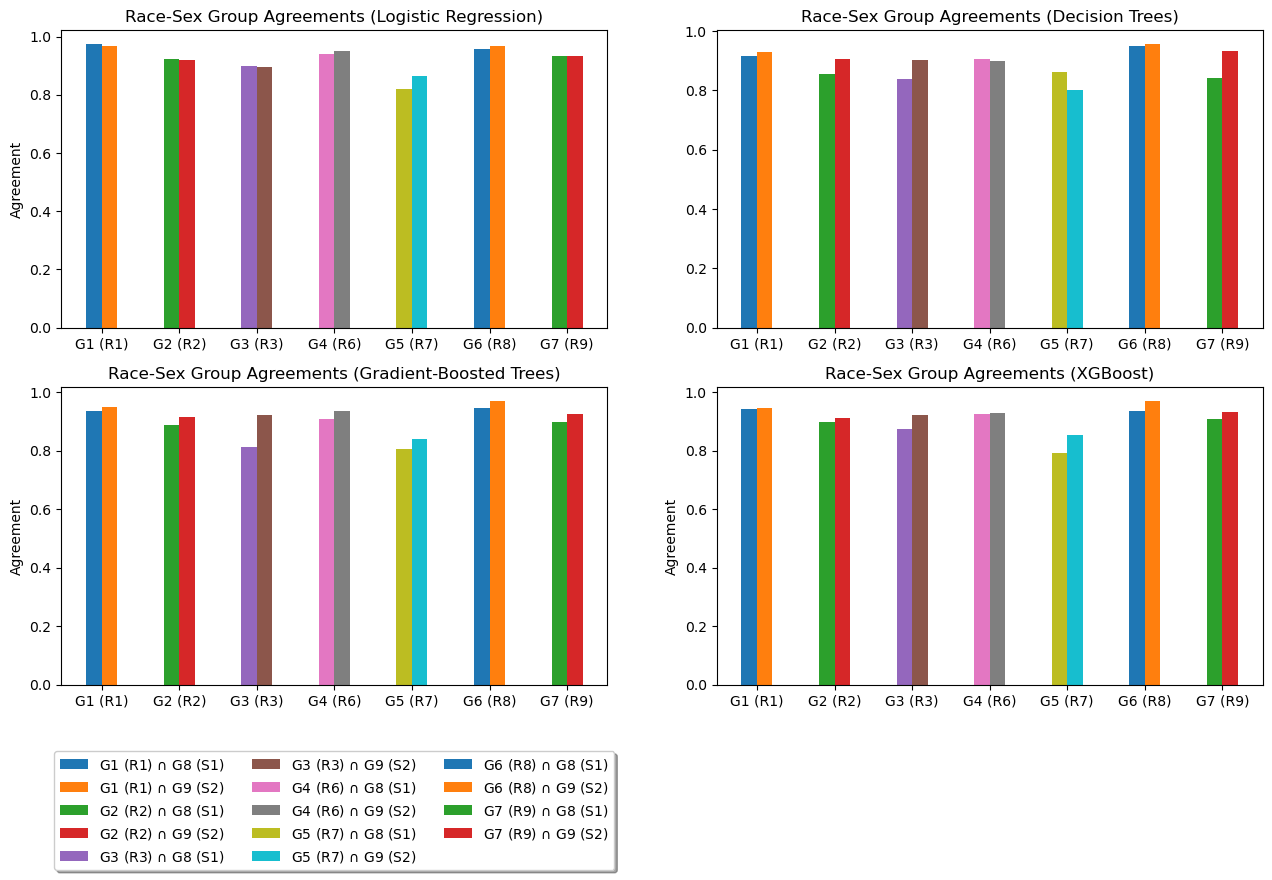

In [62]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][0].bar(int(i/2) - bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][0].bar(int(i/2) + bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Race-Sex Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# DECISON TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][1].bar(int(i/2) - bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][1].bar(int(i/2) + bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[0][1].set_title('Race-Sex Group Agreements (Decision Trees)')
ax[0][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# GRADIENT-BOOSTED TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][0].bar(int(i/2) - bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][0].bar(int(i/2) + bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Race-Sex Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# XGBOOST
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][1].bar(int(i/2) - bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][1].bar(int(i/2) + bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Race-Sex Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

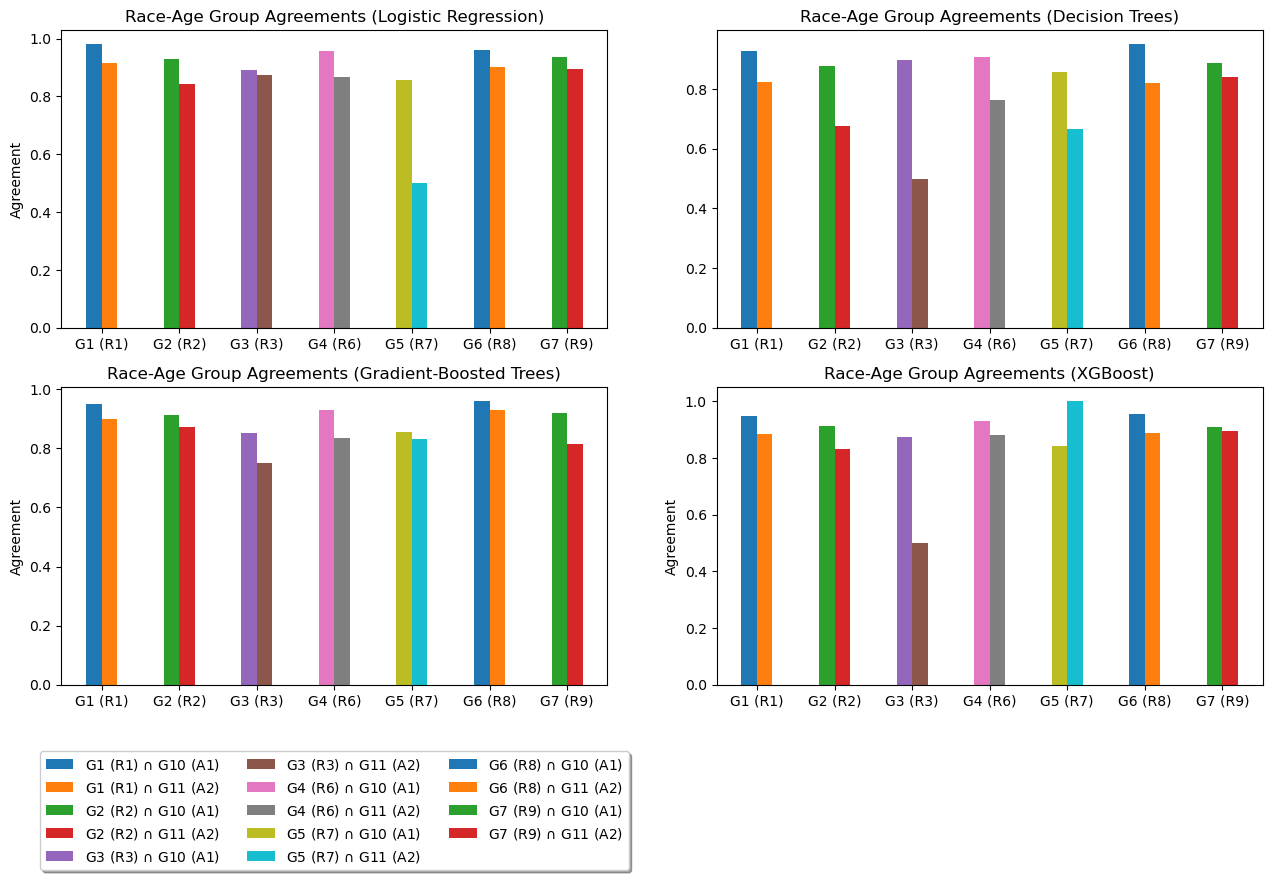

In [63]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.2

# LOGISTIC REGRESSION
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][0].bar(int(i/2) - bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][0].bar(int(i/2) + bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Race-Age Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# DECISON TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[0][1].bar(int(i/2) - bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[0][1].bar(int(i/2) + bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[0][1].set_title('Race-Age Group Agreements (Decision Trees)')
ax[0][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# GRADIENT-BOOSTED TREES
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][0].bar(int(i/2) - bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][0].bar(int(i/2) + bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Race-Age Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

# XGBOOST
for i in range(num_bars):
    if i % 2 == 0:
        ax[1][1].bar(int(i/2) - bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax[1][1].bar(int(i/2) + bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Race-Age Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

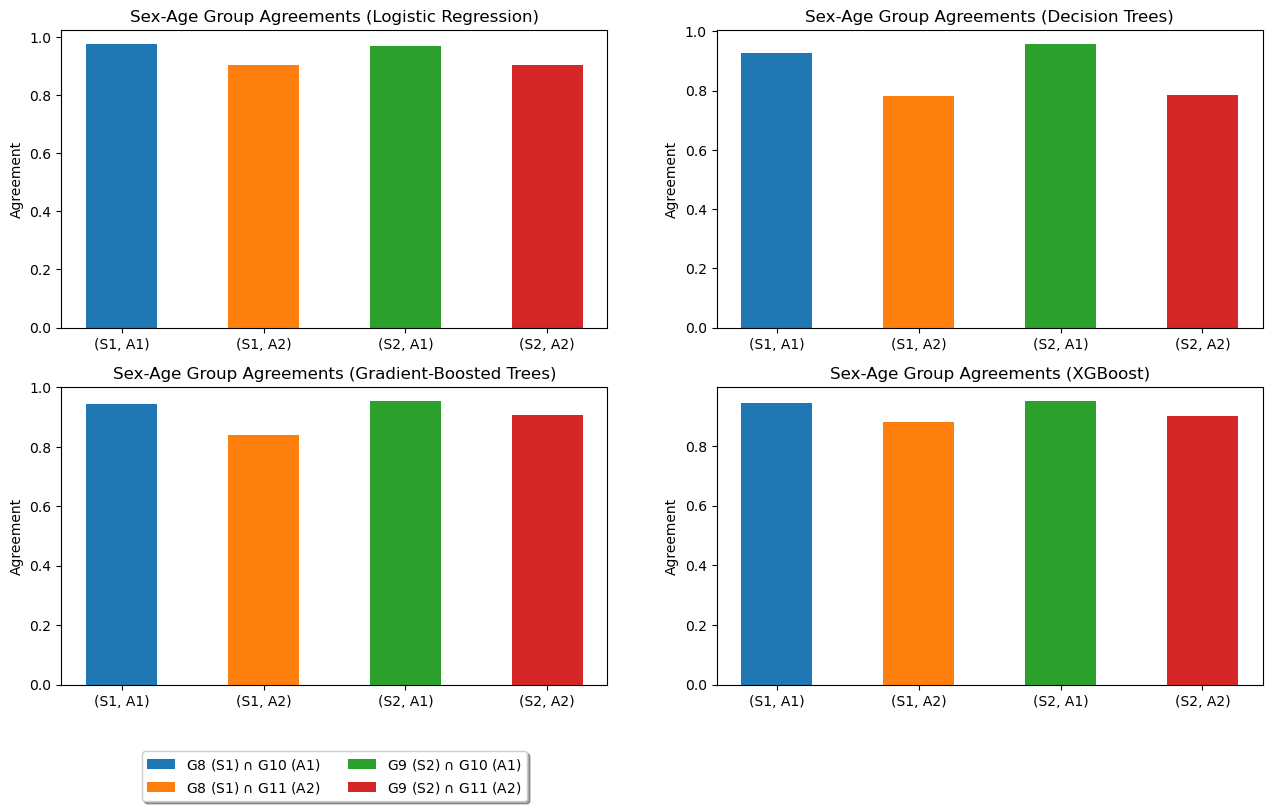

In [64]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15.5, 8.5)
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

# LOGISTIC REGRESSION
for i in range(num_bars):
    ax[0][0].bar(i, lr_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[0][0].set_ylabel('Agreement')
ax[0][0].set_title('Sex-Age Group Agreements (Logistic Regression)')
ax[0][0].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

# DECISON TREES
for i in range(num_bars):
    ax[0][1].bar(i, dt_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[0][1].set_ylabel('Agreement')
ax[0][1].set_title('Sex-Age Group Agreements (Decision Trees)')
ax[0][1].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

# GRADIENT-BOOSTED TREES
for i in range(num_bars):
    ax[1][0].bar(i, gb_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[1][0].set_ylabel('Agreement')
ax[1][0].set_title('Sex-Age Group Agreements (Gradient-Boosted Trees)')
ax[1][0].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

# XGBOOST
for i in range(num_bars):
    ax[1][1].bar(i, xgb_sex_age_agreements[i], bar_width,
                 label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[i][0], group_names[sex_age_pairs[i][0]],
                                                         sex_age_pairs[i][1], group_names[sex_age_pairs[i][1]]))
ax[1][1].set_ylabel('Agreement')
ax[1][1].set_title('Sex-Age Group Agreements (XGBoost)')
ax[1][1].set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))

ax[1][0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
plt.show()